# PLL PI Control

In [295]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline

### `scipy.signal.step` Step-Response Demo

From [SciPy docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.step.html#scipy.signal.step)

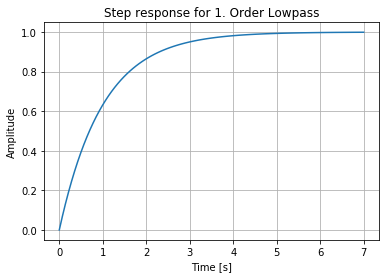

In [296]:
lti = signal.lti([1.0], [1.0, 1.0])
t, y = signal.step(lti)
plt.plot(t, y)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Step response for 1. Order Lowpass')
plt.grid()

### PI Control 

General PI-controlled system, using this [CalTech Notation](https://www.cds.caltech.edu/~murray/courses/cds101/fa04/caltech/am04_ch8-3nov04.pdf):

```
P(s) = b / (s+a)
C(s) = kp + ki/s

Hcl(s) = P(s)F(s) / (1 + P(s)F(s))
       = b*(kp*s + ki) / (s**2 + (a+b*kp)s + b*ki)
```

### PLL 

For the PI-control PLL:

```
b = M*Kd
a => 0   # DCO is a perfect integrator

Hpll(s) = M*Kd*(kp*s+ki) / (s**2 + M*Kd*kp*s + M*Kd*ki)
```

Derivations:

```
w0 = sqrt(M*Kd*Ki)
Q  = sqrt(ki/M/Kd)/Kp
td = Q / w0 
   = 1 / M / Kd / Kp
```

In [335]:
from dataclasses import dataclass

@dataclass
class PiPll(object):
    M:  float = 1.0
    Kd: float = 1.0
    ki: float = 1.0
    kp: float = 1.0
        
    @property
    def params(self):
        return (self.M, self.Kd, self.ki, self.kp)
    
    @staticmethod
    def tf(M, Kd, ki, kp):
        num = [M*Kd*kp, M*Kd*ki]
        den = [1, M*Kd*kp, M*Kd*ki]
        return num, den
        
    def calc(self): 
        """ Calculate all of our internal derived quantities
        Transfer function, bandwidth, Q, etc. """
        self.num, self.den = self.tf(*self.params)
        
        self.w0 = np.sqrt(self.M*self.Kd*self.ki)
        self.tm = 0.1 * 1/2/np.pi/self.w0
        self.Q = np.sqrt(self.ki/self.M/self.Kd)/self.kp
        self.td = self.Q / self.w0
        
    def plot(self):
        """ Plot our step response """
        lti = signal.lti(self.num, self.den)
        
        # Plot over a few time-constants
        # Note we'll need many more points with high-Q, 
        # or often plots will alias and look under-damped! 
        npoints = max(1000, int(1000*self.Q))
        timescale = np.linspace(0, 10*self.td, npoints)
        
        t, y = signal.step(lti, T=timescale)
        label=f'w0={self.w0:.2e} Q={self.Q:.2e}, td={self.td:.2e}'
        plt.plot(t, y, label=label)
        plt.legend()
        plt.grid()


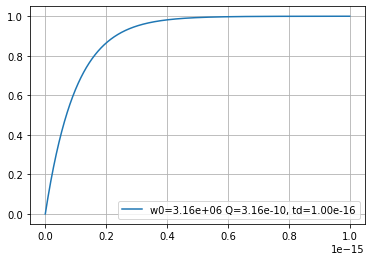

In [345]:
pll = PiPll(M=1, Kd=1e10, ki=1e3, kp=1e6)
pll.calc()
pll.plot()

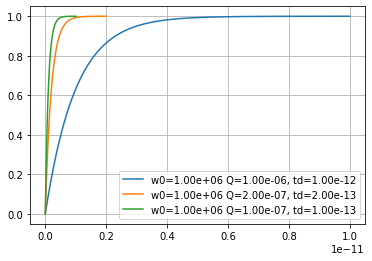

In [328]:
for kp in [1, 5, 10]:
    pll = PiPll(M=1e6, Kd=1e6, ki=1, kp=kp)
    pll.calc()
    pll.plot()